<a href="https://colab.research.google.com/github/Ahmedalichk/LangGraph/blob/main/blog_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community langgraph langsmith langchain_google_genai langchain wikipedia

In [17]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

gemini_api_key = userdata.get('GEMINI_API_KEY')


from langchain_google_genai import ChatGoogleGenerativeAI


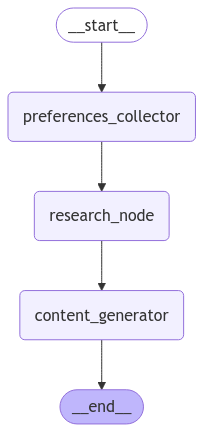





## Decoding the Enigma:  Artificial Intelligence – Friend or Foe?

Artificial intelligence (AI). The very term conjures images of futuristic robots, sentient computers, and perhaps, a touch of existential dread.  But AI isn't some far-off science fiction fantasy; it's woven into the fabric of our daily lives, from the recommendations on your Netflix queue to the voice assistant perched on your phone.  It's a powerful tool, capable of incredible feats, but understanding its complexities is key to harnessing its potential responsibly.

At its core, AI is about creating machines that exhibit intelligence – the ability to perceive their environment, learn from experience, and make decisions to achieve specific goals.  Think of the sophisticated algorithms powering Google Search, effortlessly sifting through billions of web pages to deliver relevant results in milliseconds. Or consider the recommendation systems of Amazon and Netflix, subtly influencing our purchasing and viewing habits





## More Than a Trophy: The Enduring Legacy of Quaid-e-Azam

The name "Quaid-e-Azam" – Great Leader – resonates across Pakistan, a testament to the enduring impact of Muhammad Ali Jinnah.  His legacy isn't just etched in history books; it's actively played out on the cricket field, too.  The Quaid-e-Azam Trophy, a fiercely contested domestic cricket competition, bears his name, a fitting tribute to a man who championed unity and determination.

Since its inception in 1953-54, the Trophy has witnessed countless thrilling matches and dramatic shifts in the cricketing landscape. Initially designed to help selectors choose Pakistan's Test team, the competition has evolved, reflecting the nation's own dynamic growth.  From regional rivalries to departmental clashes, the tournament has seen a variety of formats and team structures, showcasing the depth and diversity of Pakistani cricket talent.  The recent restructuring, with its focus on regional teams, highlights the ongoing effort to a

In [18]:
from typing_extensions import TypedDict
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Set up the LLM
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
gemini_flash = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0.5,
    max_retries=2,
    api_key=gemini_api_key
)

# Define State
class State(TypedDict):
    preferences: dict
    research_context: str
    generated_content: str

# Node: Collect user preferences
def preferences_collector(state: State):
    preferences = state["preferences"]
    prompt = (
        "Please provide the topic, tone (e.g., formal, humorous), and content length (e.g., short, medium, long) "
        "for your personalized content."
    )
    return {"preferences": preferences or {"prompt": prompt}}

# Node: Research and gather context
def research_node(state: State):
    topic = state["preferences"].get("topic", "")

    # Fetch Wikipedia content
    wiki_loader = WikipediaLoader(query=topic, load_max_docs=2)
    wiki_content = wiki_loader.load()

    # Fetch web search results
    tavily_search = TavilySearchResults(max_results=3)
    web_content = tavily_search.invoke(topic)

    # Combine and format content
    combined_content = "\n\n---\n\n".join(
        [
            f"Wikipedia:\n{doc.page_content}" for doc in wiki_content
        ] +
        [
            f"Web:\n{doc['content']}" for doc in web_content
        ]
    )

    return {"research_context": combined_content}

# Node: Generate personalized content
def content_generator(state: State):
    preferences = state["preferences"]
    context = state["research_context"]
    tone = preferences.get("tone", "neutral")
    length = preferences.get("length", "medium")

    prompt = (
        f"Generate a {length} article with a {tone} tone on the topic of {preferences.get('topic', 'general interest')}.\n\n"
        f"Use the following context for accuracy:\n\n{context}"
    )

    generated_content = gemini_flash.invoke([
        SystemMessage(content=prompt),
        HumanMessage(content="Please generate the personalized content.")
    ])

    return {"generated_content": generated_content}

# Build and compile the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("preferences_collector", preferences_collector)
builder.add_node("research_node", research_node)
builder.add_node("content_generator", content_generator)

# Define edges
builder.add_edge(START, "preferences_collector")
builder.add_edge("preferences_collector", "research_node")
builder.add_edge("research_node", "content_generator")
builder.add_edge("content_generator", END)

# Compile and visualize the graph
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

# run
result = graph.invoke({"preferences": {"topic": "Artificial Intelligence", "tone": "engaging", "length": "medium"}})
print("\n\n\n")

print(result["generated_content"].content)

print("\n\n\n")

# run
result = graph.invoke({"preferences": {"topic": "Quaid-e-Azam", "tone": "engaging", "length": "short"}})
print("\n\n\n")

print(result["generated_content"].content)
